In [1]:
"""
1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. 
Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Построить случайный лес, вывести важность признаков
3. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
В качестве решения: Jupyter notebook с кодом, комментариями и графиками
"""

import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler # Стандартизация функций путем удаления среднего 
                                                  # и масштабирования до единичной дисперсии
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data = pd.read_csv('train.csv')
data

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114316,228708,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,AL,NaN,NaN,NaN,0,NaN,NaN
114317,228710,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,E,NaN,NaN,NaN,1,NaN,NaN
114318,228711,1,NaN,NaN,C,NaN,10.069277,NaN,NaN,0.323324,...,NaN,NaN,0.156764,Q,NaN,NaN,2.417606,2,NaN,NaN
114319,228712,1,NaN,NaN,C,NaN,10.106144,NaN,NaN,0.309226,...,NaN,NaN,0.490658,BW,NaN,NaN,3.526650,0,NaN,NaN


In [3]:
# удалим пустые строки с записью NaN
data_filtred = data.dropna()

#Находим категориальные признаки
cat_feat = list(data_filtred.dtypes[data_filtred.dtypes == object].index)

#закодируем пропущенные значений строкой (факт пропущенного значения тоже может нести в себе информацию)
# data_filtred[cat_feat] = data_filtred[cat_feat].fillna('NaN')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = data_filtred[cat_feat].nunique()                       # nunique() возвращает количество уникальных объектов
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 20 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 20].index)


v3         2
v22     6998
v24        5
v30        7
v31        3
v47        7
v52       12
v56       62
v66        3
v71        3
v74        2
v75        2
v79       11
v91        7
v107       7
v110       2
v112      22
v113      34
v125      86
dtype: int64


In [4]:
# Разбиваем на train/test
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in splitter.split(data_filtred, data_filtred.target):
    d_train = data_filtred.iloc[train_index]
    d_test = data_filtred.iloc[test_index]
    
    y_train = data_filtred['target'].iloc[train_index]
    y_test = data_filtred['target'].iloc[test_index]

In [5]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)  # преобразовываем категориальную переменную 
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)    # в фиктивные / индикаторные переменные

dummy_cols = list(set(dummy_train) & set(dummy_test))           # сет уникальных (set) колонок категорий признаков

dummy_train_q = dummy_train[dummy_cols]                         # обучающийся сет категориальных признаков 
dummy_test_q = dummy_test[dummy_cols]                           # тестовый сет категориальных признаков

In [6]:
# Обучаем решающее дерево
# Немного ограничим глубину и минимальное кол-во объектов в листе для уменьшения переобучения


X_train = pd.concat([d_train[num_feat],
                     dummy_train_q], axis=1)

X_test = pd.concat([d_test[num_feat],
                     dummy_test_q], axis=1)

clf_tree = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [7]:
# проверим качество модели
clf_tree.score(X_test, y_test)

0.6697635135135135

In [8]:
# Построим на графике кривую ROC и рассчитаем площадь AUC
# Для этого напишем функцию show_auc

def show_auc(y, y_pred, plot_label='', prin=True):    
    fpr, tpr, threshold = roc_curve(y, y_pred)   
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

Train:
ROC AUC: 0.8620
Test:
ROC AUC: 0.6367


0.6366758983588061

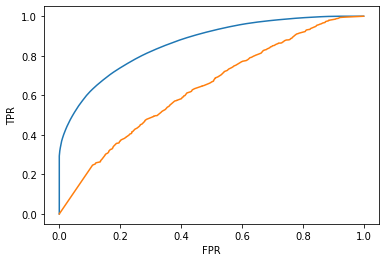

In [9]:
# Подставим данные датасета: 
# качество модели считаем по обеим выборкам (трейн и тест): если качество на трейне хорошее, 
# а на тесте сильно падает - это переобучение
# забегая вперед (изучив полученные ниже данные этой ячейки), отметим: так и есть - модель переобучилась 
# причем показатель площади под кривой тестовой выборки достаточно близко соотносится со значением метрики score 
# (равной 0.6661)

# для получения более качественных характеристик модели есть смысл перебрать параметры обучения (например, глубину разбиений
# или n_splits - количество итераций перетасовки и разбиений и т.д.). Также мы отбросили часть категориальных признаков 
# (где число значений меньше 20): можно поварьировать этим параметром 

y_pred_test = clf_tree.predict_proba(X_test)[:, 1]
y_pred_train = clf_tree.predict_proba(X_train)[:, 1]

print('Train:')
show_auc(y_train, y_pred_train, 'train')
print('Test:')
show_auc(y_test, y_pred_test, 'test')


In [10]:
# построим модель методом случайного леса
# данный метод есть беггинг для деревьев: совершаются выборки и затем на основе их ответов имеем итоговую оценку (классификацию)

# Создаем дамми-переменные для категорий
dummy_f = pd.get_dummies(data_filtred[cat_feat], columns=cat_feat)  # преобразовываем категориальную переменную 
dummy_cols = list(set(dummy_f))                              # сет уникальных (set) колонок категорий признаков
dummy_fo = dummy_f[dummy_cols]                         # сет категориальных признаков 

X = pd.concat([data_filtred[num_feat],
                     dummy_fo], axis=1)
y = data_filtred['target']

# разделим выборку на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

# обучим модель на 10-ти деревьях
# n_jobs - количество заданий, которые будут выполняться параллельно для fit и predict. None означает 1
# -1 - использование всех процессоров, т.е. реализуем возможность распараллеливания процесса
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=7, min_samples_leaf=25, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_train, y_train)  

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Train RandomeForest:
ROC AUC: 0.7697
Test RandomeForest:
ROC AUC: 0.7062


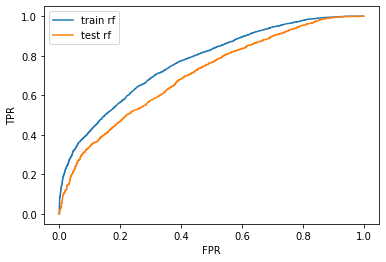

In [11]:
# Подставим данные датасета: качество модели считаем по обеим выборкам (трейн и тест)
# Здесь мы видим, что качество модели явно выше, чем при построении одного дерева
# Можно заклчить, что лес работает лучше одного дерева
# Наблюдается некоторое переобучение, но это опять же связано с настройками обучения 

y_pred_test_f = clf_rf.predict_proba(X_test)[:, 1]
y_pred_train_f = clf_rf.predict_proba(X_train)[:, 1]


print('Train RandomeForest:')
show_auc(y_train, y_pred_train_f, 'train rf')
print('Test RandomeForest:')
show_auc(y_test, y_pred_test_f, 'test rf')
plt.legend()

In [12]:
# Оценим важность признаков для прогнозирования 
# Для случайного леса важности лежат в артибуте feature_importances_

imp = pd.Series(clf_rf.feature_importances_)
imp.sort_values(ascending=False)

43     0.357025
158    0.088274
130    0.053558
119    0.034254
172    0.034222
         ...   
147    0.000000
115    0.000000
152    0.000000
153    0.000000
184    0.000000
Length: 185, dtype: float64

In [13]:
# Обучим стекинг 3-х моделей, используя хотя бы 1 линейную модель и 1 нелинейную
# Вначале подготовим признаки для обучения 


train_median = d_train[num_feat].median()                         # для обучаемого сета находим медианное значение

X_train = pd.concat([d_train[num_feat].fillna(train_median),      # обрабатываем пустые значения, если таковые имеются
                     d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(train_median),
                     d_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

scaler = StandardScaler()
scaler.fit(X_train[num_feat])

X_train[num_feat] = scaler.transform(X_train[num_feat])
X_test[num_feat] = scaler.transform(X_test[num_feat])


In [14]:
# Займемся непосредственым обученем стекинга 
# Финальное решение в стеке обучающихся моделей принимает логистическая регрессия  

classifier = StackingClassifier(
    [
        ('lr', LogisticRegression()),
        ('dt', DecisionTreeClassifier()),
        ('knn', KNeighborsClassifier())
    ],
LogisticRegression())
classifier.fit(X_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [14204, 12429]